## Import required packages 

In [123]:
import pandas as pd 
import numpy as np

import requests

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

%matplotlib inline

## Extract stock prices for each 

In [124]:
def get_stock_prices(api_key, tckr ): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signin up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [125]:
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

pred_stock = 'o_GLW'

In [126]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,4697536.0,36.2105,35.97,36.11,36.525,35.872,2023-01-23 05:00:00,41530,4743714.0,39.4718,...,253.27,243.50,3744,289683.0,132.1434,133.00,132.23,133.26,131.3600,6597
1,3469967.0,35.9481,36.05,35.81,36.205,35.480,2023-01-24 05:00:00,34870,4968706.0,39.7341,...,255.46,247.60,3773,209051.0,131.3895,132.10,131.20,132.53,130.4648,4464
2,4334809.0,35.4321,35.49,35.56,35.640,35.025,2023-01-25 05:00:00,39349,7761076.0,39.1836,...,251.71,246.31,3401,296371.0,131.9778,130.00,133.60,134.47,129.3600,5950
3,4777904.0,36.2280,35.72,36.43,36.440,35.720,2023-01-26 05:00:00,51171,5834620.0,39.1989,...,254.13,246.50,4826,228450.0,134.5502,133.45,135.36,135.41,132.9000,4868
4,4588693.0,36.8311,36.33,36.80,37.040,36.295,2023-01-27 05:00:00,41879,5188690.0,39.2769,...,256.37,250.20,3688,178757.0,135.9170,134.76,136.57,136.57,134.7600,5286


## See if any data is missing 

In [127]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [128]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [129]:
# No missing data, all has been pulled through from the API 

## Explore the data 

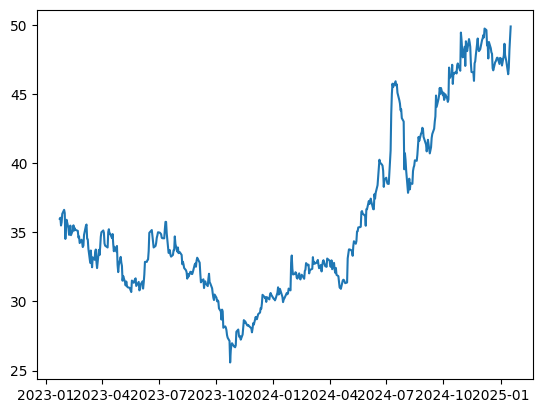

In [130]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df[pred_stock])

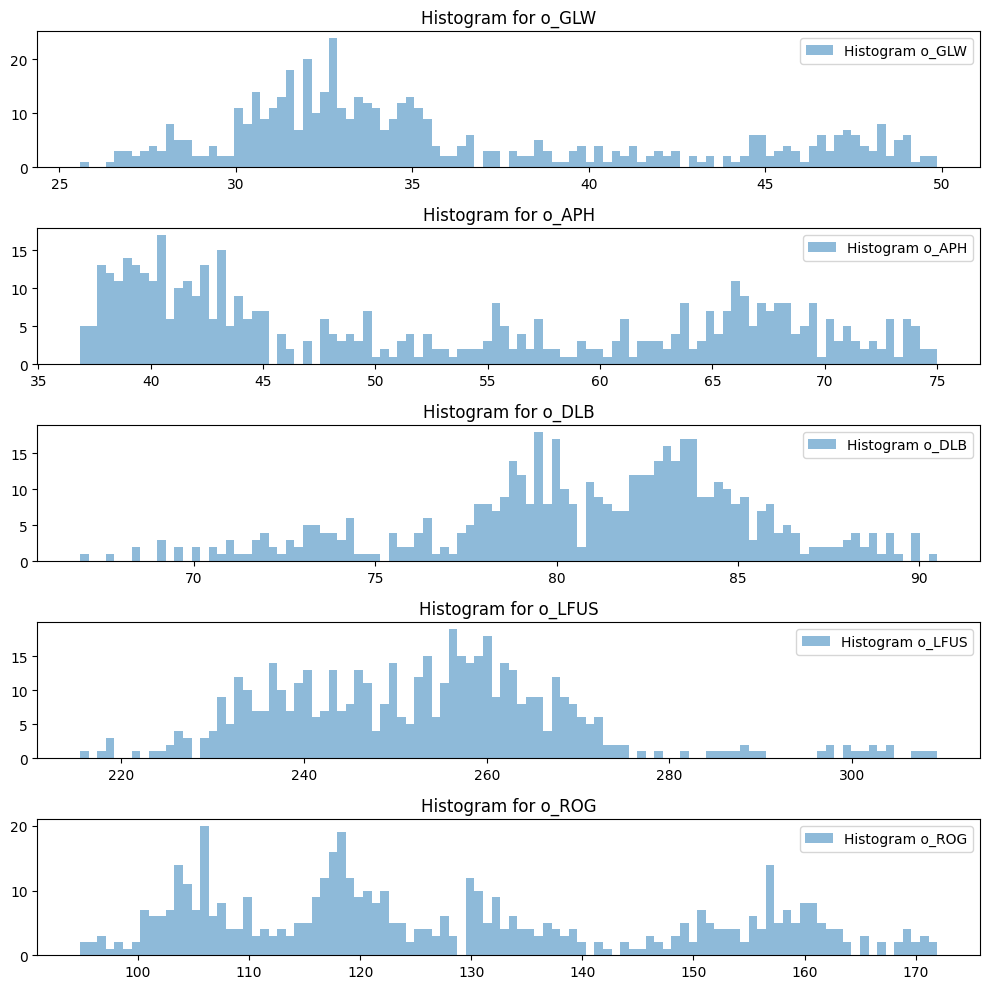

In [131]:
# Most stocks are not normally distributed so make sure methods do not include this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks[:5]):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Auto regression 
Understand if previous values in previous time series contribute to fucture 

In [132]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    correlations = []
    lagged_cols = {}
    for lag in range(min_lag, max_lag + 1):
        lagged_cols[f'{col}_lagged_{lag}'] = df[col].shift(lag)
    
    lagged_df = pd.DataFrame(lagged_cols)
    target_series = df[target_col]
    
    for lag in range(min_lag, max_lag + 1):
        correlation = target_series.corr(lagged_df[f'{col}_lagged_{lag}'])
        correlations.append({'lag': lag, 'correlation': correlation})
    
    correlation_df = pd.DataFrame(correlations)
    return correlation_df

def generate_top_correlations(df, target_col=pred_stock, min_lag=5, max_lag=6):
    all_correlations = []
    for col in df.columns:
        if col == 't':
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df)
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Get the top one correlation from each column by magnitude
    top_correlations = all_correlations_df.loc[all_correlations_df.groupby('column')['correlation'].apply(lambda x: x.abs().idxmax())]
    
    # Select only the relevant columns
    top_correlations = top_correlations[['column', 'lag', 'correlation']]
    
    return top_correlations

In [133]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28 * 6)

In [134]:
def plot_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' :
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 1))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

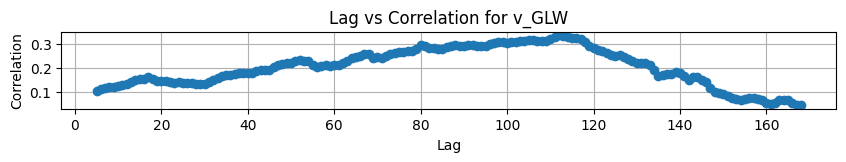

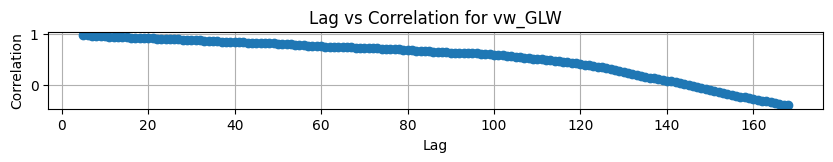

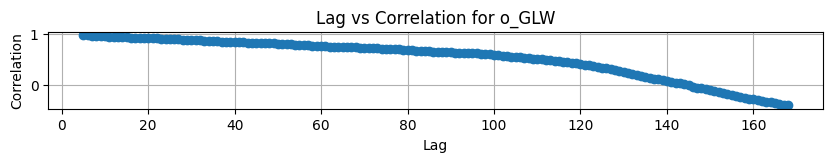

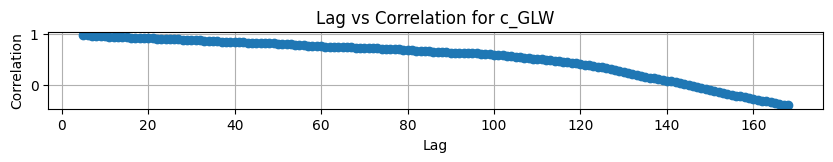

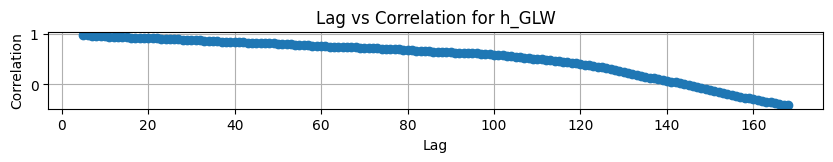

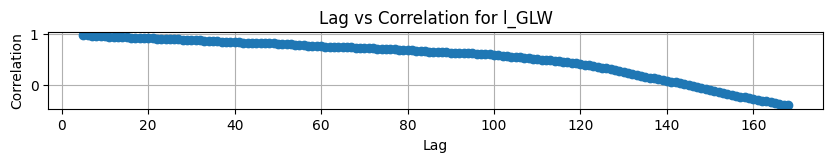

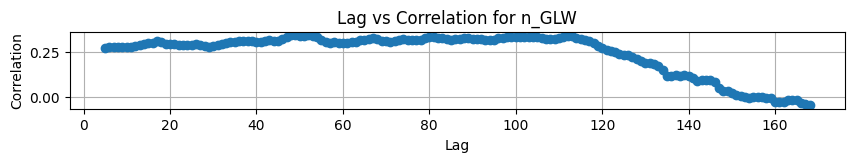

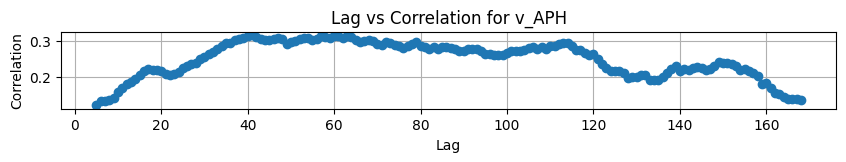

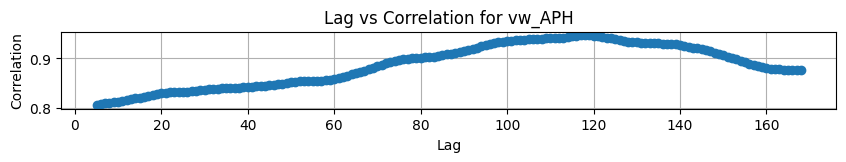

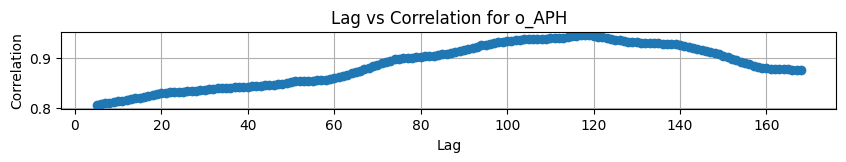

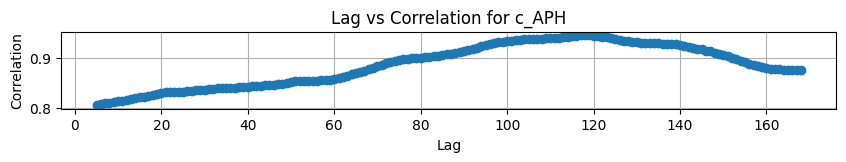

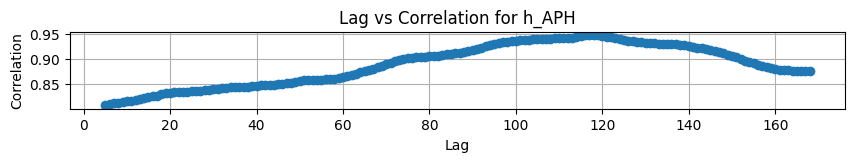

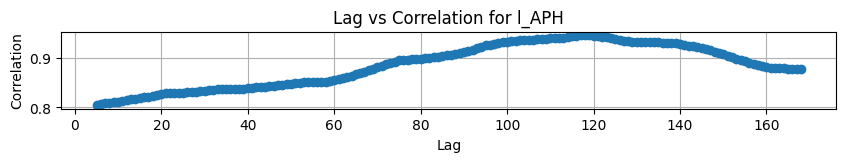

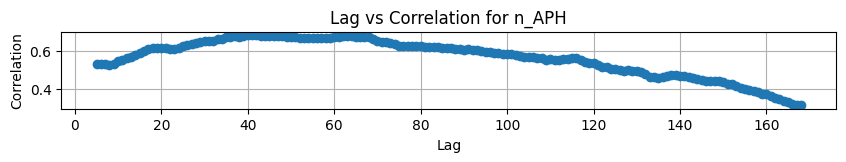

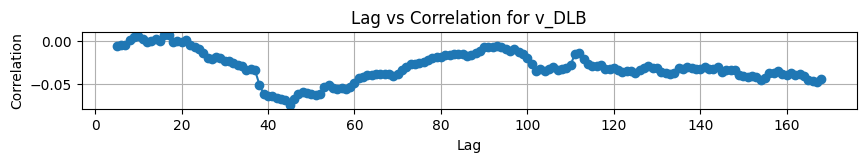

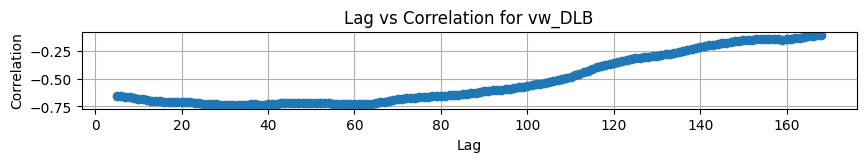

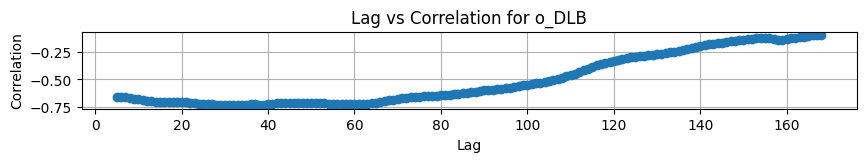

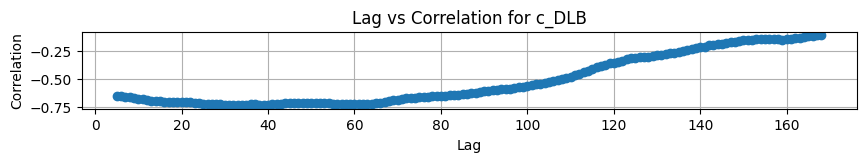

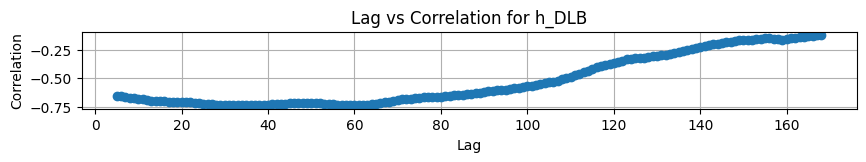

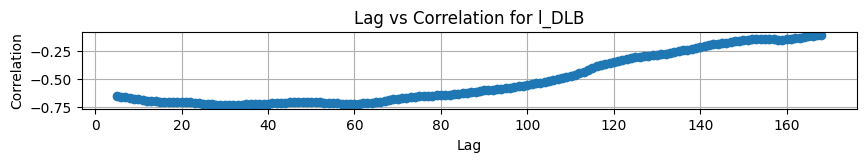

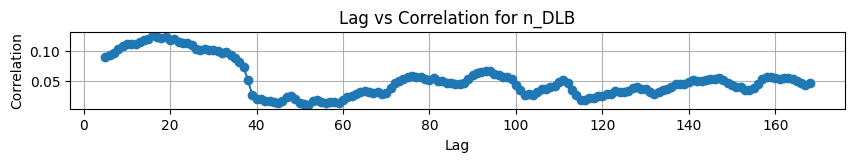

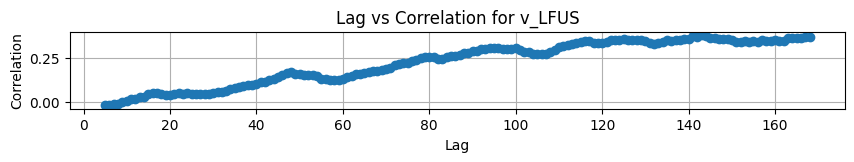

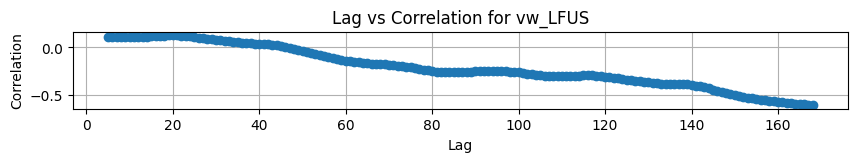

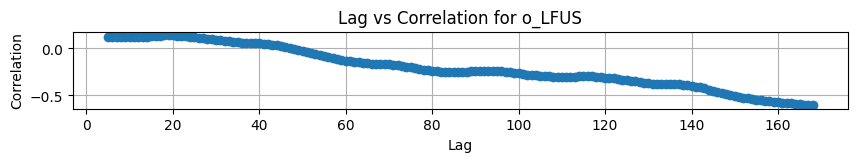

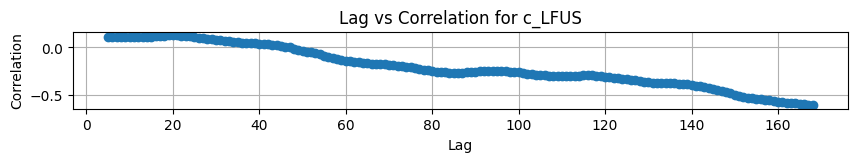

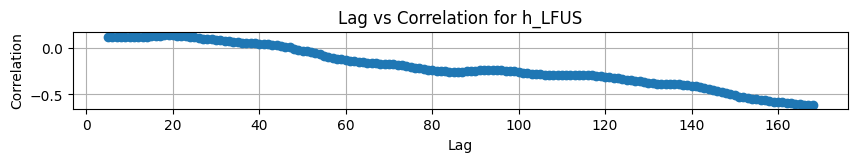

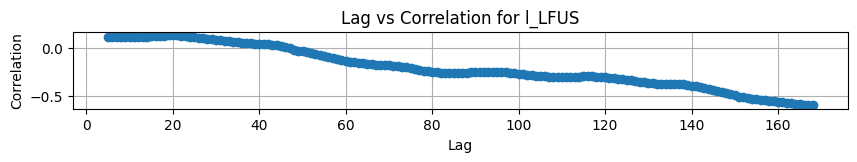

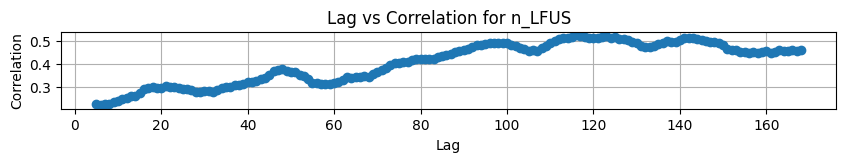

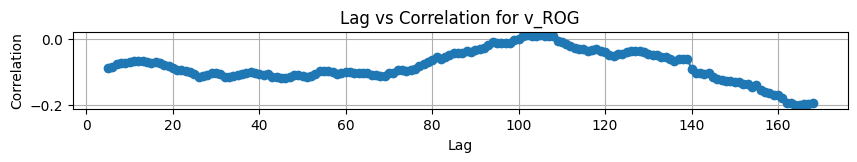

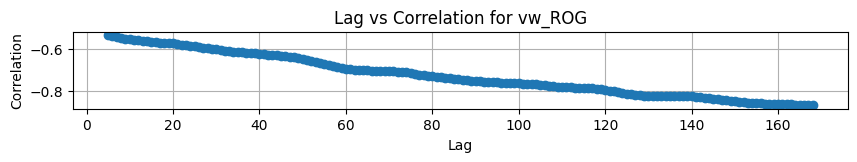

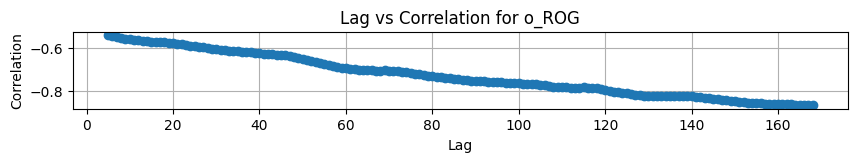

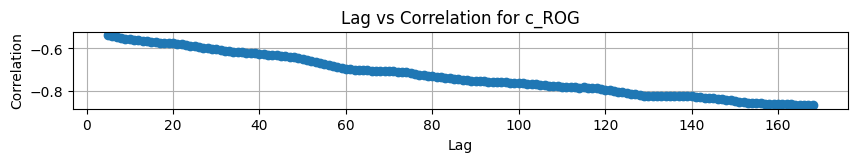

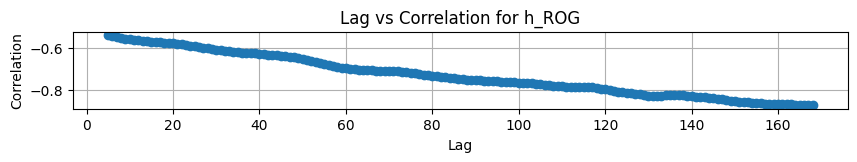

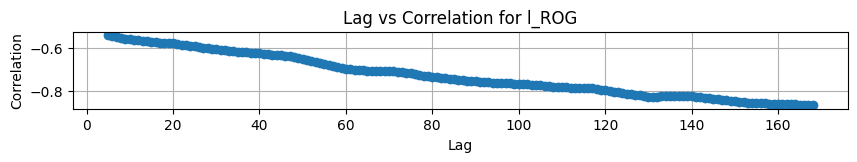

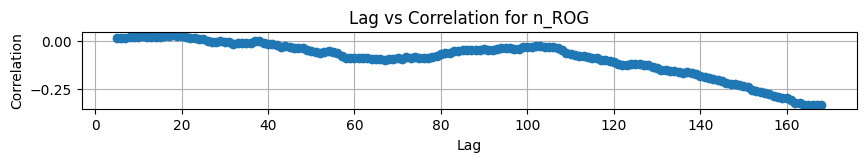

In [135]:
# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

In [136]:
top_corr_columns

,column,lag,correlation
113,v_GLW,118,0.305951
113,vw_GLW,118,0.434724
113,o_GLW,118,0.431795
113,c_GLW,118,0.436978
113,h_GLW,118,0.431098
...,...,...,...
163,o_ROG,168,-0.868035
163,c_ROG,168,-0.869424
163,h_ROG,168,-0.873383
163,l_ROG,168,-0.864991


In [137]:
lagged_df = pd.DataFrame()

for index, row in top_corr_columns.iterrows():
    column_name = row['column']
    lag_amount = row['lag']
    
    # Shift the column by the specified lag amount
    lagged_column = stock_prices_df[column_name].shift(lag_amount)
    
    # Add the lagged column to the new dataframe
    lagged_df[column_name] = lagged_column

# Drop rows with NaN values resulting from the lagging process
lagged_df.dropna(inplace=True)

In [138]:
# 99% of autocorrelation variation done by 2 previous columns 
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(lagged_df)

# Convert PCA result to a dataframe
pca_df = pd.DataFrame(pca_result)

In [139]:
# Ensure the indices match for concatenation
pca_df.index = lagged_df.index

# Add the PCA columns to the original stock_prices_df
for i in range(pca_df.shape[1]):
    stock_prices_df[f"PCA_{i+1}"] = pca_df.iloc[:, i]

# Print the updated dataframe
stock_prices_df.tail(10)

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG,PCA_1,PCA_2,PCA_3
490,3134535.0,47.2737,47.05,47.50,47.5300,46.76,2025-01-03 05:00:00,41979,4299852.0,69.9662,...,60060.0,100.1775,99.32,100.75,101.0300,98.500,3071,8.780385e+05,-7.693773e+05,323143.742227
491,3591531.0,48.1433,47.78,48.34,48.4600,47.58,2025-01-06 05:00:00,39571,4161428.0,71.4735,...,127234.0,103.2004,101.29,102.68,106.1200,101.290,4006,6.832101e+05,2.898202e+06,118875.379780
492,3306393.0,48.0381,48.62,47.85,48.7300,47.61,2025-01-07 05:00:00,37602,4952158.0,71.4317,...,88610.0,101.1665,102.69,100.95,103.3500,100.405,3725,1.038549e+06,-1.697952e+06,327725.081543
493,2874155.0,47.4983,47.80,47.73,47.8814,47.08,2025-01-08 05:00:00,33693,6345923.0,71.4073,...,84452.0,98.3832,99.80,98.43,99.9700,97.040,3154,4.044317e+04,-7.899599e+05,-177212.581226
494,3573013.0,47.0884,47.36,47.12,47.4400,46.91,2025-01-10 05:00:00,33866,4379853.0,70.4156,...,113093.0,95.5997,96.46,95.39,96.9500,94.090,4018,-1.274239e+06,-1.092606e+06,-179051.437977
495,4455826.0,46.5000,46.42,46.58,46.8700,46.19,2025-01-13 05:00:00,48541,6586630.0,68.0865,...,144255.0,94.9591,94.80,94.78,95.8599,94.160,4581,-1.555549e+06,-6.209601e+05,-142230.471389
496,2903878.0,47.2820,46.90,47.43,47.5500,46.86,2025-01-14 05:00:00,33925,6049402.0,69.9137,...,94189.0,94.7888,94.87,95.01,95.9250,93.810,4089,-2.026421e+06,-8.145048e+05,-146904.588274
497,4007155.0,48.7258,48.18,48.81,48.9050,48.16,2025-01-15 05:00:00,40004,5706414.0,71.1775,...,83348.0,96.1841,97.03,95.92,97.2950,95.500,3685,1.158066e+06,2.058807e+06,97737.533416
498,2911877.0,49.1218,49.09,49.24,49.3100,48.80,2025-01-16 05:00:00,34096,6187837.0,70.1712,...,71010.0,95.5376,95.60,95.68,96.1250,94.480,3743,5.198595e+05,-2.089050e+06,-104910.991620
499,5317767.0,49.9373,49.87,49.84,50.3200,49.50,2025-01-17 05:00:00,48962,9048893.0,69.4403,...,92750.0,96.1187,96.78,95.77,97.2000,95.315,3926,2.003414e+06,-1.745020e+06,15689.869504


# Moving averages and time series analysis

In [141]:
pred_stock

'o_GLW'

### Moving Average 

In [145]:
def calculate_mse(df, window, prediction_days):
    df['moving_average'] = df[pred_stock].rolling(window=window).mean()
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['moving_average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future
results = []

for window in range(1, 29):
    mse = calculate_mse(stock_prices_df, window, 5)
    results.append({'window': window, 'mse': mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

In [146]:
results_df


,window,mse
0,1,0.000000
1,2,0.085779
2,3,0.187784
3,4,0.294025
4,5,0.403567
5,6,0.516351
6,7,0.634904
7,8,0.757098
8,9,0.882034
9,10,1.006038


#  GARCH

# Model out changes over time 

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors